In [8]:
import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from dataloaders.dataset import VideoDataset
from network import R3D_model, C3D_model, R2Plus1D_model, HM3D_model, Pac3D_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

In [9]:

############################
####    Check GPU       ####
############################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

############################
####    Parameters      ####
############################
nEpochs = 10  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 20 # Run on test set every nTestInterval epochs
snapshot = 10 # Store a model every snapshot epochs
lr = 1e-3 # Learning rate

###################################
####    Options of Dataset     ####
###################################
dataset = 'pac4' # Options: hmdb51 or ucf101

if dataset == 'hmdb51':
    num_classes = 51
elif dataset == 'ucf101':
    num_classes = 10
elif dataset == 'pac4':
    num_classes = 4
else:
    print('We only implemented hmdb and ucf datasets.')
    raise NotImplementedError


Device being used: cuda:0


In [10]:

##########################################
####   Set Model result saving dir    ####
##########################################
save_dir_root = os.path.join("/SSD/ne6101157/image_captioning/modelpath")
exp_name = "Pac3D"

resume_epoch = 0
if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = max([int(i.split('_')[-1]) for i in runs]) + 1
save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))

modelName = 'C3D' # Options: C3D or R2Plus1D or R3D or Pac3D or HMR3D
saveName = modelName + '-' + dataset



In [11]:

# def train_model(dataset=dataset, save_dir=save_dir, num_classes=num_classes, lr=lr,
#                 num_epochs=nEpochs, save_epoch=snapshot, useTest=useTest, test_interval=nTestInterval):
#     """
#         Args:
#             num_classes (int): Number of classes in the data
#             num_epochs (int, optional): Number of epochs to train for.
#     """
num_epochs = nEpochs
test_interval = nTestInterval
save_epoch = snapshot
######################################
####   Load model & parameters    ####
######################################
if modelName == 'C3D':
    model = C3D_model.C3D(num_classes=num_classes, pretrained=False)
    train_params = [{'params': C3D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': C3D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R2Plus1D':
    model = R2Plus1D_model.R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = [{'params': R2Plus1D_model.get_1x_lr_params(model), 'lr': lr},
                    {'params': R2Plus1D_model.get_10x_lr_params(model), 'lr': lr * 10}]
elif modelName == 'R3D':
    model = R3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
elif modelName == 'HMR3D':
    model = HM3D_model.R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
elif modelName == 'Pac3D':
    model = Pac3D_model.Pac3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
    train_params = model.parameters()
else:
    print('We only implemented C3D and R2Plus1D models.')
    raise NotImplementedError


In [12]:

######################################
####   Load model & parameters    ####
######################################
criterion = nn.CrossEntropyLoss()  # standard crossentropy loss for classification
optimizer = optim.Adam(train_params, lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                        gamma=0.1)  # the scheduler divides the lr by 10 every 10 epochs

if resume_epoch == 0:
    print("Training {} from scratch...".format(modelName))
else:
    checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                    map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
    print("Initializing weights from: {}...".format(
        os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['opt_dict'])

print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
model.to(device)
criterion.to(device)

# log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
# print(log_dir)
# writer = SummaryWriter(log_dir=log_dir)


Training C3D from scratch...
Total params: 36.21M


CrossEntropyLoss()

In [13]:

########################
####   Load Data    ####
########################
print('Training model on {} dataset...'.format(dataset))
train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train',clip_len=512), batch_size=4, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(VideoDataset(dataset=dataset, split='val',  clip_len=512), batch_size=4, num_workers=0)
test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=512), batch_size=4, num_workers=0)

trainval_loaders = {'train': train_dataloader, 'val': val_dataloader}
trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ['train', 'val']}
test_size = len(test_dataloader.dataset)


Training model on pac4 dataset...
root: /SSD/ne6101157/pac4
output_dir: /SSD/ne6101157/pac4
Number of train videos: 513
root: /SSD/ne6101157/pac4
output_dir: /SSD/ne6101157/pac4
Number of val videos: 129
root: /SSD/ne6101157/pac4
output_dir: /SSD/ne6101157/pac4
Number of test videos: 162


In [14]:

train_losses = []
train_accs = []
val_losses = []
val_accs = []
y_pred = []
y_true = []

for epoch in range(resume_epoch, num_epochs):
    # each epoch has a training and validation step
    for phase in ['train', 'val']:
        start_time = timeit.default_timer()

        # reset the running loss and corrects
        running_loss = 0.0
        running_corrects = 0.0

        # set model to train() or eval() mode depending on whether it is trained
        # or being validated. Primarily affects layers such as BatchNorm or Dropout.
        if phase == 'train':
            # scheduler.step() is to be called once every epoch during trainin
            model.train()
        else:
            model.eval()

        for inputs, labels in tqdm(trainval_loaders[phase]):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            optimizer.zero_grad()

            if phase == 'train':
                outputs = model(inputs)
            else:
                with torch.no_grad():
                    outputs = model(inputs)

            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / trainval_sizes[phase]
        epoch_acc = running_corrects.double() / trainval_sizes[phase]

        if phase == 'train':
            # writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
            # writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            # writer.add_scalar('data/val_loss_epoch', epoch_loss, epoch)
            # writer.add_scalar('data/val_acc_epoch', epoch_acc, epoch)
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)
            
        print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format(phase, epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
    if epoch % save_epoch == (save_epoch - 1):
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'opt_dict': optimizer.state_dict(),
        }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
        print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

    if useTest and epoch % test_interval == (test_interval - 1):
        model.eval()
        start_time = timeit.default_timer()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects.double() / test_size
    
        # writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
        # writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)


        print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
# writer.close()
# torch.save(model.state_dict(), "/SSD/ne6101157/image_captioning/modelpath/run/model_param/"+modelName+"_"+datetime.now().strftime('%b%d_%H-%M-%S')+".pth")


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:01<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_SUPPORTED. This error may appear if you passed in a non-contiguous input.

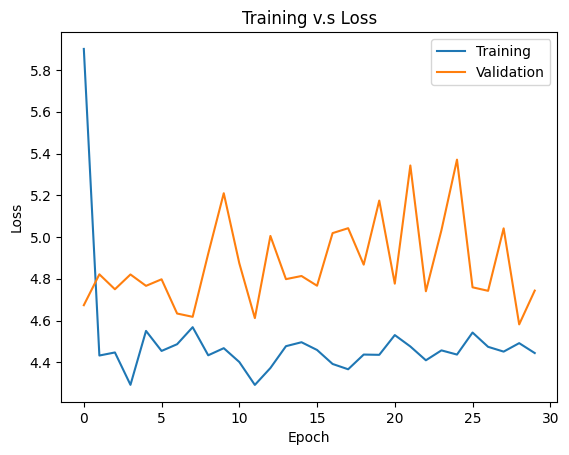

In [ ]:
import matplotlib.pyplot as plt
x = list(range(nEpochs))
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.title('Training v.s Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

plt.show()

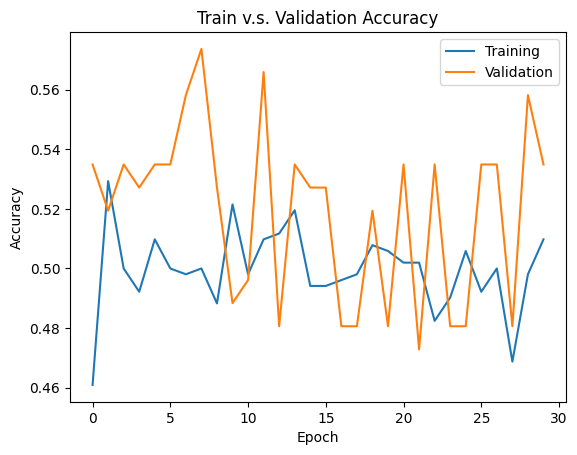

In [ ]:
import numpy as np
x = list(range(nEpochs))
np_train_accs = []
np_val_accs = []
for i in range(len(train_accs)):
    np_train_accs.append(train_accs[i].cpu().numpy())
for i in range(len(val_accs)):
    np_val_accs.append(val_accs[i].cpu().numpy())

plt.plot(x, np_train_accs)
plt.plot(x, np_val_accs)
plt.title('Train v.s. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    y_pred = []   #保存預測label
    y_true = []   #保存實際label
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            # move inputs and labels to the device the training is taking place on
            labels = labels.type(torch.LongTensor)
            inputs = Variable(inputs, requires_grad=True).to(device)
            labels = Variable(labels).to(device)
            outputs = model(inputs)
            probs = nn.Softmax(dim=1)(outputs)
            preds = torch.max(probs, 1)[1]
            num_samples += 1
            num_correct += torch.sum(preds == labels.data)
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(labels.view(-1).detach().cpu().numpy())
        acc = num_correct.double() / test_size
        print("[test] Acc: {}".format(acc))
    return y_pred, y_true
        

In [ ]:
checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(19) + '.pth.tar'),
                    map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
print("Initializing weights from: {}...".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_dict'])
y_pred, y_true = check_accuracy(test_dataloader, model)


Initializing weights from: /SSD/ne6101157/image_captioning/modelpath/run/run_17/models/Pac3D-pac4_epoch--1.pth.tar...


100%|██████████| 41/41 [00:13<00:00,  3.08it/s]

[test] Acc: 0.49382716049382713


In [ ]:
num_correct = 0
num_correct += torch.sum(preds == labels.data)
acc = running_corrects.double() / test_size
print("[test] Acc: {}".format(acc))

[test] Acc: 0.42592592592592593


['GoldenEye', 'Heartbleed', 'LOIC', 'SSHpatator']
[0.45       0.95652174 1.         0.        ]
Plot confusion matrix


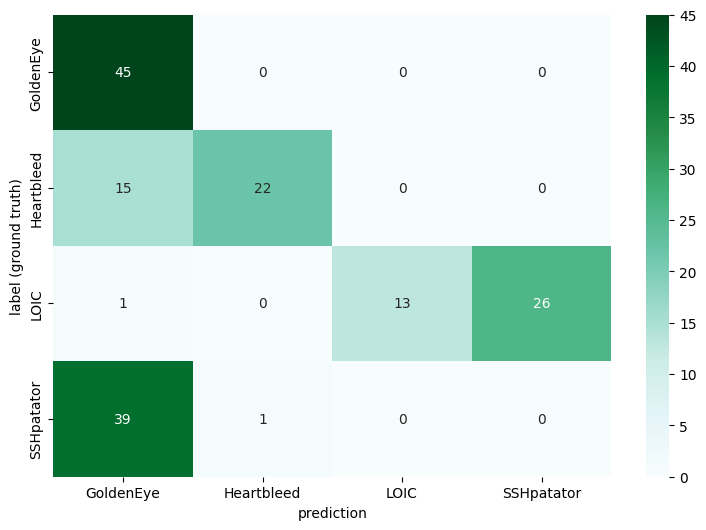

In [ ]:

# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)                               
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                   
class_names = ['GoldenEye', 'Heartbleed', 'LOIC', 'SSHpatator']
print(class_names)
print(per_cls_acc)                                                          #顯示每個class的Accuracy
print("Plot confusion matrix")

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix, class_names, class_names)     # https://sofiadutta.github.io/datascience-ipynbs/pytorch/Image-Classification-using-PyTorch.html
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig("./src/"+ modelName+ "confusion_matrix.png")